In [1]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow_addons as tfa

from sklearn.metrics import log_loss
from tqdm.notebook import tqdm

import warnings

warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## Loading the data

In [3]:
train_features = pd.read_csv('../input/train_features.csv')
train_targets = pd.read_csv('../input/train_targets_scored.csv')
train_non_targets = pd.read_csv('../input/train_targets_nonscored.csv')

test_features = pd.read_csv('../input/test_features.csv')
sample_submission = pd.read_csv('../input/sample_submission.csv')

In [4]:
train_features.head(1)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.062,0.5577,-0.2479,-0.6208,-0.1944,-1.012,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176


In [5]:
train_non_targets.head(1)

,sig_id,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## EDA Non-targets

In [6]:
train_non_targets.head(1)

,sig_id,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

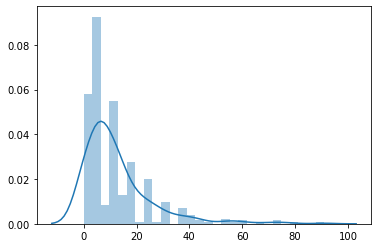

In [7]:
values = np.sum(train_non_targets.iloc[:, 1:], axis = 0)

sns.distplot(values)

## Creating folds

In [8]:
def create_fold(data):
    
    data['fold'] = -1
    
    data = data.sample(frac = 1).reset_index(drop = True)
    
    targets = data.drop('sig_id', axis=1).values
    
    splitter = MultilabelStratifiedKFold(n_splits=7, random_state=0)
    
    for fold, (train, valid) in enumerate(splitter.split(X=data, y=targets)):
        
        data.loc[valid, 'fold'] = fold
        
    return data

In [9]:
combined = train_targets.merge(train_non_targets, on='sig_id', how='outer')
combined = create_fold(combined)
train_targets['fold'] = combined['fold']
train_non_targets['fold'] = combined['fold']

del(combined)

In [10]:
train_targets.to_csv('../output/fold_data_targets.csv', index = False)

In [11]:
train_non_targets.to_csv('../output/fold_data_non_targets.csv', index = False)

## Preprocessing the data

In [12]:
def preprocess(data):
    
    cp_time = pd.get_dummies(data['cp_time'])
    cp_type = pd.get_dummies(data['cp_type'])
    cp_dose = pd.get_dummies(data['cp_dose'])
    
    
    data = data.join(cp_time)
    data = data.join(cp_type)
    data = data.join(cp_dose)
    
    data.drop(columns = ['cp_time', 'cp_dose', 'cp_type'], inplace=True)
    
    return data

In [13]:
train_features = preprocess(train_features)

## Unifying the data

In [14]:
def uni_non_targets():
    train_df = train_features.merge(train_non_targets, on='sig_id', how='outer')   
    return train_df

## Create model and metric

In [15]:
def create_model(num_inputs, num_outputs):
    
    model = tf.keras.Sequential([
        
        tf.keras.layers.Input(num_inputs),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        
        tfa.layers.WeightNormalization(tf.keras.layers.Dense(2048, activation="relu")),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        tfa.layers.WeightNormalization(tf.keras.layers.Dense(1048, activation="relu")),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        tfa.layers.WeightNormalization(tf.keras.layers.Dense(num_outputs, activation="sigmoid"))
        
    ])
    
    
    model.compile(optimizer=tfa.optimizers.Lookahead(tf.optimizers.Adam(), sync_period=10),
                  loss='binary_crossentropy', 
                  )
    
    return model

In [16]:
def metric(y_true, y_pred):
    
    metrics = []
    
    for _target in train_targets.columns[1:-1]:
        
        metrics.append(log_loss(y_true.loc[:, _target], y_pred.loc[:, _target].astype(float), labels=[0,1]))
        
    return np.mean(metrics)

## Method-1

In this we will make a simple model and use it to predict the target labels.

In [17]:
train_df = train_features.merge(train_targets, on='sig_id', how='outer')

In [18]:
def run_model(fold):
    
    train_df = train_features.merge(train_targets, on='sig_id', how='outer')
    
    # defining the parameters
    cols = train_df.columns
    
    ID = cols[0]
    fold_col = cols[-1]
    features = cols[1:880]
    # we are skipping the mid (947th column) as it is the fold column of the previous part
    targets = cols[880:-1]
    
    # loading the data
    train = train_df[train_df['fold'] != fold]
    valid = train_df[train_df['fold'] == fold]
    
    x_train = train.loc[:, features]
    x_valid = valid.loc[:, features]
    
    y_train = train.loc[:, targets]
    y_valid = valid.loc[:, targets]
    
    # creating the model
    model = create_model(x_train.shape[1], y_train.shape[1])
    
    # Defining model callbacks
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, epsilon=1e-4, mode='min')
    
    checkpoint_path = f'Fold_{fold}_basic.hdf5'
    
    cb_checkpt = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=0, save_best_only=True, 
                                save_weights_only=True, mode='min')
    
    # Fitting the model
    model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=35, batch_size=128,
             callbacks = [reduce_lr_loss, cb_checkpt], verbose=1)
    
    # Loading the best model
    model.load_weights(checkpoint_path)
    
    # Making the predictions
    y_valid_pred = model.predict(x_valid)
    
    # converting the predictions to dataframe
    y_valid_pred = pd.DataFrame(y_valid_pred, columns=y_valid.columns)
    
    # Evaluating the final results
    print('\n\n\n')
    print('OOF Metric: ', metric(y_valid, y_valid_pred))
    
    return

In [19]:
run_model(0)

Epoch 1/35
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
160/160 [==============================] - 2s 15ms/step - loss: 0.5839 - val_loss: 0.2814 - lr: 0.0010
Epoch 2/35
160/160 [==============================] - 2s 13ms/step - loss: 0.1310 - val_loss: 0.0545 - lr: 0.0010
Epoch 3/35
160/160 [==============================] - 3s 17ms/step - loss: 0.0418 - val_loss: 0.0285 - lr: 0.0010
Epoch 4/35
160/160 [==============================] - 2s 13ms/step - loss: 0.0277 - val_loss: 0.0230 - lr: 0.0010
Epoch 5/35
160/160 [==============================] - 2s 14ms/step - loss: 0.0231 - val_loss: 0.0206 - lr: 0.0010
Epoch 6/35
160/160 [==============================] - 2s 13ms/step - loss: 0.0210 - val_loss: 0.0193 - lr: 0.0010
Epoch 7/35
160/160 [==============================] - 2s 13ms/step - loss: 0.0198 - val_loss: 0.0186 - lr: 0.0010
Epoch 8/35
160/160 [==============================] - 2s 13ms/step - loss: 0.0191 - val_loss: 0.0180 - lr: 0.0010
Epoch 9

## Method-2

In this we will make a model to predict the train_non_scored columns and then we will merge that with the data we have as features and then we will use that whole data as our feature vector.

In [20]:
def run_part1(fold):
    
    # loading the targets_non_scored concatinated data
    train_df = uni_non_targets()
    
    # defining the parameters
    cols = train_df.columns
    
    ID = cols[0]
    fold_col = cols[-1]
    features = cols[1:880]
    targets = cols[880:-1]
    
    # loading the data
    train = train_df[train_df['fold'] != fold]
    valid = train_df[train_df['fold'] == fold]
    
    x_train = train.loc[:, features]
    x_valid = valid.loc[:, features]
    
    y_train = train.loc[:, targets]
    y_valid = valid.loc[:, targets]
    
    # creating the model
    model = create_model(x_train.shape[1], y_train.shape[1])
    
    # Defining model callbacks
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, epsilon=1e-4, mode='min')
    
    checkpoint_path = f'Fold_{fold}_part1.hdf5'
    
    cb_checkpt = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=0, save_best_only=True, 
                                save_weights_only=True, mode='min')
    
    # Fitting the model
    model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=35, batch_size=128,
             callbacks = [reduce_lr_loss, cb_checkpt], verbose=1)
    
    # Loading the best weights model
    model.load_weights(checkpoint_path)
    
    # Making the predictions
    y_valid_pred = model.predict(x_valid)
    y_train_pred = model.predict(x_train)
    
    # converting the y_preds
    y_valid_pred = pd.DataFrame(y_valid_pred, columns = y_valid.columns)
    y_train_pred = pd.DataFrame(y_train_pred, columns = y_valid.columns)
    
    # replacing the train_df with the predicted data
    train_df.loc[:, targets][train_df['fold'] != fold] = y_train_pred
    train_df.loc[:, targets][train_df['fold'] == fold] = y_valid_pred
    
    # drop this fold
    train_df.drop(columns='fold', inplace=True)
    
    return train_df

In [21]:
def run_part2(fold):
    
    # Prepairing final data
    features = run_part1(fold)
    targets = train_targets
    
    # Merging both
    train_df = features.merge(targets, on='sig_id', how='outer')
    
    # defining the parameters
    cols = train_df.columns
    
    ID = cols[0]
    fold_col = cols[-1]
    features = cols[1:947]
    # we are skipping the mid (947th column) as it is the fold column of the previous part
    targets = cols[948:-1]
    
    # loading the data
    train = train_df[train_df['fold'] != fold]
    valid = train_df[train_df['fold'] == fold]
    
    x_train = train.loc[:, features]
    x_valid = valid.loc[:, features]
    
    y_train = train.loc[:, targets]
    y_valid = valid.loc[:, targets]
    
    # creating the model
    model = create_model(x_train.shape[1], y_train.shape[1])
    
    # Defining model callbacks
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, epsilon=1e-4, mode='min')
    
    checkpoint_path = f'Fold_{fold}_part1.hdf5'
    
    cb_checkpt = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=0, save_best_only=True, 
                                save_weights_only=True, mode='min')
    
    # Some blanck lines
    print('\n\n\n')
    
    
    # Fitting the model
    model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=35, batch_size=128,
             callbacks = [reduce_lr_loss, cb_checkpt], verbose=1)
    
    # Loading the best model
    model.load_weights(checkpoint_path)
    
    # Making the predictions
    y_valid_pred = model.predict(x_valid)
    
    # converting the predictions to dataframe
    y_valid_pred = pd.DataFrame(y_valid_pred, columns=y_valid.columns)
    
    # Evaluating the final results
    print('\n\n\n')
    print('OOF Metric: ', metric(y_valid, y_valid_pred))
    
    return

In [22]:
def run(fold):
    
    run_part2(fold)

In [23]:
run(0)

Epoch 1/35
160/160 [==============================] - 3s 17ms/step - loss: 0.5768 - val_loss: 0.2549 - lr: 0.0010
Epoch 2/35
160/160 [==============================] - 2s 15ms/step - loss: 0.1123 - val_loss: 0.0402 - lr: 0.0010
Epoch 3/35
160/160 [==============================] - 2s 15ms/step - loss: 0.0279 - val_loss: 0.0174 - lr: 0.0010
Epoch 4/35
160/160 [==============================] - 2s 15ms/step - loss: 0.0140 - val_loss: 0.0109 - lr: 0.0010
Epoch 5/35
160/160 [==============================] - 3s 16ms/step - loss: 0.0095 - val_loss: 0.0074 - lr: 0.0010
Epoch 6/35
160/160 [==============================] - 2s 15ms/step - loss: 0.0075 - val_loss: 0.0064 - lr: 0.0010
Epoch 7/35
160/160 [==============================] - 5s 32ms/step - loss: 0.0063 - val_loss: 0.0055 - lr: 0.0010
Epoch 8/35
160/160 [==============================] - 2s 15ms/step - loss: 0.0057 - val_loss: 0.0052 - lr: 0.0010
Epoch 9/35
160/160 [==============================] - 2s 16ms/step - loss: 0.0052 - val_

160/160 [==============================] - 3s 17ms/step - loss: 0.0082 - val_loss: 0.0082 - lr: 0.0010
Epoch 28/35
160/160 [==============================] - 3s 18ms/step - loss: 0.0081 - val_loss: 0.0082 - lr: 0.0010
Epoch 29/35
160/160 [==============================] - 3s 18ms/step - loss: 0.0080 - val_loss: 0.0081 - lr: 0.0010
Epoch 30/35
159/160 [============================>.] - ETA: 0s - loss: 0.0082
Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
160/160 [==============================] - 2s 14ms/step - loss: 0.0082 - val_loss: 0.0082 - lr: 0.0010
Epoch 31/35
160/160 [==============================] - 3s 16ms/step - loss: 0.0078 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 32/35
160/160 [==============================] - 3s 16ms/step - loss: 0.0078 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 33/35
160/160 [==============================] - 3s 17ms/step - loss: 0.0078 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 34/35
160/160 [===========================

### Although The OOF Metric didn't changed for the better but if you look at the validation_loss you will see that it is lower in Method2 in compare to Method1.

## Method-3

This is based upon the term "Gene Sequence". What if the Sequence could give us better results.

In [24]:
def Seq_model(num_inputs, num_outputs):
    
    model = tf.keras.Sequential([
        
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024), input_shape=(1, num_inputs)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        tfa.layers.WeightNormalization(tf.keras.layers.Dense(1048, activation="relu")),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        tfa.layers.WeightNormalization(tf.keras.layers.Dense(num_outputs, activation="sigmoid"))
        
    ])
    
    
    model.compile(optimizer=tfa.optimizers.Lookahead(tf.optimizers.Adam(), sync_period=10),
                  loss='binary_crossentropy', 
                  )
    
    return model

In [30]:
def run_seq_model(fold):
    
    train_df = train_features.merge(train_targets, on='sig_id', how='outer')
    
    # defining the parameters
    cols = train_df.columns
    
    ID = cols[0]
    fold_col = cols[-1]
    features = cols[1:880]
    # we are skipping the mid (947th column) as it is the fold column of the previous part
    targets = cols[880:-1]
    
    # loading the data
    train = train_df[train_df['fold'] != fold]
    valid = train_df[train_df['fold'] == fold]
    
    x_train = train.loc[:, features]
    x_valid = valid.loc[:, features]
    
    y_train = train.loc[:, targets]
    y_valid = valid.loc[:, targets]
    
    
    # reshaping the data for LSTM
    x_train = np.array(x_train).reshape(-1, 1, 879)
    x_valid = np.array(x_valid).reshape(-1, 1, 879)
    
    # creating the model
    model = Seq_model(x_train.shape[2], y_train.shape[1])
    
    # Defining model callbacks
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, epsilon=1e-4, mode='min')
    
    checkpoint_path = f'Fold_{fold}_Seq.hdf5'
    
    cb_checkpt = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=0, save_best_only=True, 
                                save_weights_only=True, mode='min')
    
    # Fitting the model
    model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=35, batch_size=128,
             callbacks = [reduce_lr_loss, cb_checkpt], verbose=1)
    
    # Loading the best model
    model.load_weights(checkpoint_path)
    
    # Making the predictions
    y_valid_pred = model.predict(x_valid)
    
    # converting the predictions to dataframe
    y_valid_pred = pd.DataFrame(y_valid_pred, columns=y_valid.columns)
    
    # Evaluating the final results
    print('\n\n\n')
    print('OOF Metric: ', metric(y_valid, y_valid_pred))
    
    return

In [31]:
run_seq_model(0)

Epoch 1/35
160/160 [==============================] - 6s 39ms/step - loss: 0.5830 - val_loss: 0.2603 - lr: 0.0010
Epoch 2/35
160/160 [==============================] - 5s 34ms/step - loss: 0.1283 - val_loss: 0.0463 - lr: 0.0010
Epoch 3/35
160/160 [==============================] - 6s 34ms/step - loss: 0.0406 - val_loss: 0.0274 - lr: 0.0010
Epoch 4/35
160/160 [==============================] - 6s 34ms/step - loss: 0.0270 - val_loss: 0.0220 - lr: 0.0010
Epoch 5/35
160/160 [==============================] - 6s 35ms/step - loss: 0.0230 - val_loss: 0.0201 - lr: 0.0010
Epoch 6/35
160/160 [==============================] - 6s 35ms/step - loss: 0.0208 - val_loss: 0.0187 - lr: 0.0010
Epoch 7/35
160/160 [==============================] - 6s 37ms/step - loss: 0.0196 - val_loss: 0.0180 - lr: 0.0010
Epoch 8/35
160/160 [==============================] - 6s 39ms/step - loss: 0.0186 - val_loss: 0.0173 - lr: 0.0010
Epoch 9/35
160/160 [==============================] - 6s 39ms/step - loss: 0.0180 - val_

## Making Submissions

In [33]:
sample_submission.head(2)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,id_001897cda,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [34]:
test_features.head(2)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.0981,0.7978,-0.143,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.151,-0.775
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,-0.1190,-0.1852,-1.031,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.381,-0.730


### Method-1

In [36]:
test_features = preprocess(test_features)

In [37]:
model = create_model(879, 206)

model.load_weights('Fold_0_basic.hdf5')

pred = model.predict(test_features.iloc[:, 1:])

In [42]:
pred = pd.DataFrame(pred, columns = train_targets.columns.values[1:-1])

sub_file1 = sample_submission.copy()
sub_file1.iloc[:, 1:] = pred

In [44]:
sub_file1.to_csv('sub1.csv', index=False)